<a href="https://colab.research.google.com/github/ChacoGolden/DSML_EV/blob/main/train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import pandas as pd
import numpy as np

In [28]:
# Load your datasets (use your own file paths in Colab)
no2_df = pd.read_csv("https://raw.githubusercontent.com/ChacoGolden/DSML_EV/refs/heads/main/No2_emissions_CH.csv")
ev_df = pd.read_csv("https://raw.githubusercontent.com/ChacoGolden/DSML_EV/refs/heads/main/CH_vehicles_ev_percentage.csv")
swiss_df = pd.read_csv('https://raw.githubusercontent.com/ChacoGolden/DSML_EV/refs/heads/main/swiss_final_dataset_1995_2023.csv')

In [41]:
no2_df.head()

,year,no2
0,2000,49.2
1,2001,43.3
2,2002,47.0
3,2003,52.1
4,2004,48.0


In [42]:
swiss_df['EV Share'] = swiss_df['Electricity'] / swiss_df['Fossil']
swiss_df['log_population'] = np.log(swiss_df['population'])
swiss_df = pd.merge(no2_df, swiss_df, on='year', how='inner')

swiss_df.head()

,year,no2,population,avg_temp,industry_pct_gdp,Electricity,Fossil,EV Share,log_population
0,2000,49.2,7204000,5.99,25.468196,5188.0,4579530.0,0.001133,15.790147
1,2001,43.3,7256000,5.46,26.244258,5194.0,4701367.0,0.001105,15.797339
2,2002,47.0,7314000,6.08,26.433977,5307.0,4803609.0,0.001105,15.805301
3,2003,52.1,7364000,6.24,26.006421,5325.0,4882971.0,0.001091,15.812114
4,2004,48.0,7415102,5.40,25.551510,4813.0,4964380.0,0.000970,15.819029


# Train-Test with only EV% and NO2

Linear regression

In [43]:
# Define X and y
X = swiss_df[['EV Share']]
y = swiss_df[['no2']]

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 7.844356508159256
MAE: 2.6895179856170808
R² Score: 0.8466701229835955


In [64]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define X and y
X = swiss_df[['EV Share']]
y = swiss_df[['no2']]

# Initialize model
model = LinearRegression()

# Set up 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Define custom scoring functions
mse_scorer = make_scorer(mean_squared_error)
mae_scorer = make_scorer(mean_absolute_error)
r2_scorer = make_scorer(r2_score)

# Perform cross-validation
mse_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
mae_scores = cross_val_score(model, X, y, cv=kf, scoring=mae_scorer)
r2_scores = cross_val_score(model, X, y, cv=kf, scoring=r2_scorer)

# Print average scores
print("Average MSE:", np.mean(mse_scores))
print("Average MAE:", np.mean(mae_scores))
print("Average R² Score:", np.mean(r2_scores))


Average MSE: 30.679816697881922
Average MAE: 4.526096283091892
Average R² Score: 0.37204471606258044


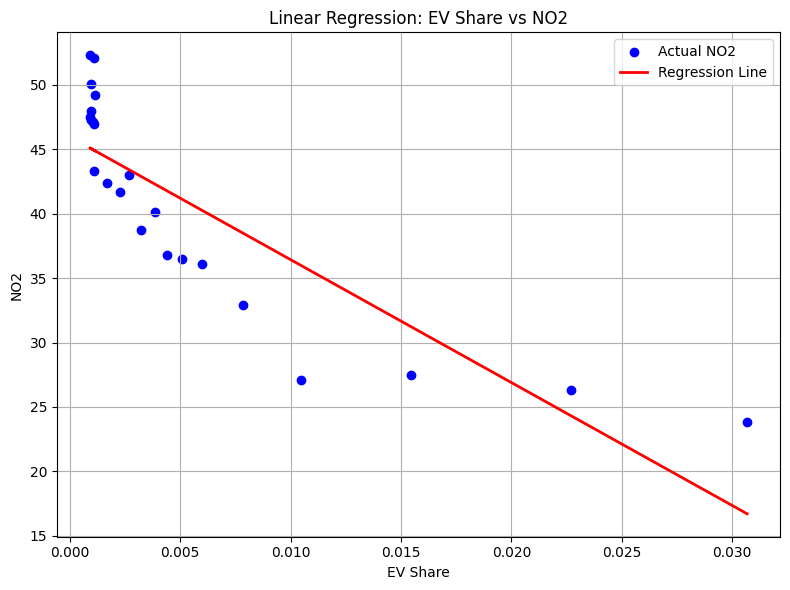

In [55]:
# Define X and y
X = swiss_df[['EV Share']]
y = swiss_df[['no2']]

# Fit the regression model on the full data
model = LinearRegression()
model.fit(X, y)

# Predict y values using the fitted model
y_pred = model.predict(X)

# Plot actual data and regression line
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', label='Actual NO2')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('EV Share')
plt.ylabel('NO2')
plt.title('Linear Regression: EV Share vs NO2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

polynomial regression degree 2

MSE: 28.586091072446266
MAE: 4.450032754749516
R² Score: 0.4412413785682904


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


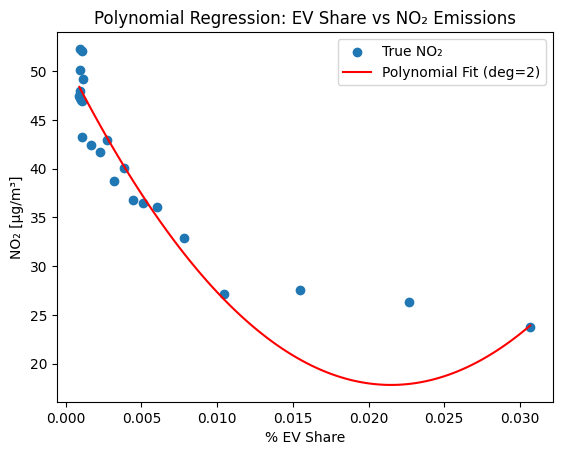

In [53]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 2. Define X and y
X = swiss_df[['EV Share']]
y = swiss_df[['no2']]

# 3. Transform features into polynomial (degree = 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# 5. Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# 7. Plot the curve
import numpy as np
x_range = np.linspace(X['EV Share'].min(), X['EV Share'].max(), 100).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_range_pred = model.predict(x_range_poly)

plt.scatter(X, y, label='True NO₂')
plt.plot(x_range, y_range_pred, color='red', label='Polynomial Fit (deg=2)')
plt.xlabel('% EV Share')
plt.ylabel('NO₂ [μg/m³]')
plt.title('Polynomial Regression: EV Share vs NO₂ Emissions')
plt.legend()
plt.show()

In [65]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define X and y
X = swiss_df[['EV Share']]
y = swiss_df[['no2']]

# Define the pipeline: PolynomialFeatures + LinearRegression
degree = 2
model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Define scorers
mse_scorer = make_scorer(mean_squared_error)
mae_scorer = make_scorer(mean_absolute_error)
r2_scorer = make_scorer(r2_score)

# Perform cross-validation
mse_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
mae_scores = cross_val_score(model, X, y, cv=kf, scoring=mae_scorer)
r2_scores = cross_val_score(model, X, y, cv=kf, scoring=r2_scorer)

# Print average scores
print("Polynomial degree:", degree)
print("Average MSE:", np.mean(mse_scores))
print("Average MAE:", np.mean(mae_scores))
print("Average R² Score:", np.mean(r2_scores))


Polynomial degree: 2
Average MSE: 25.679067974311334
Average MAE: 3.350482465188631
Average R² Score: 0.5110139770652965


Polynomial regression degree 2

MSE: 4.24740622954743
MAE: 1.6596351117874115
R² Score: 0.9169779861308165


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


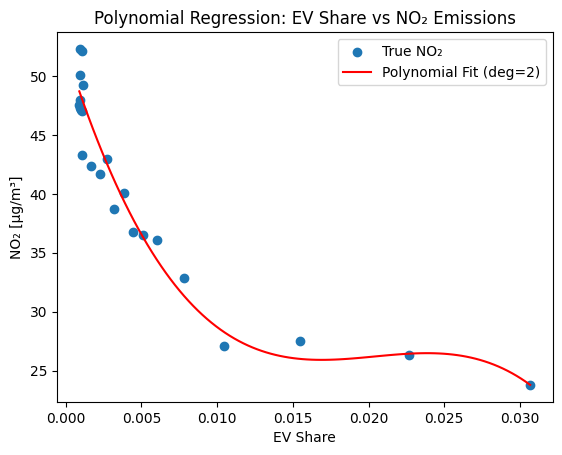

In [54]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 2. Define X and y
X = swiss_df[['EV Share']]
y = swiss_df[['no2']]

# 3. Transform features into polynomial (degree = 3)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# 5. Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# 7. Plot the curve
import numpy as np
x_range = np.linspace(X['EV Share'].min(), X['EV Share'].max(), 100).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_range_pred = model.predict(x_range_poly)

plt.scatter(X, y, label='True NO₂')
plt.plot(x_range, y_range_pred, color='red', label='Polynomial Fit (deg=2)')
plt.xlabel('EV Share')
plt.ylabel('NO₂ [μg/m³]')
plt.title('Polynomial Regression: EV Share vs NO₂ Emissions')
plt.legend()
plt.show()

In [67]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define X and y
X = swiss_df[['EV Share']]
y = swiss_df[['no2']]

# Define the pipeline for Polynomial Regression with degree 3
degree = 3
model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Define scorers
mse_scorer = make_scorer(mean_squared_error)
mae_scorer = make_scorer(mean_absolute_error)
r2_scorer = make_scorer(r2_score)

# Perform cross-validation
mse_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
mae_scores = cross_val_score(model, X, y, cv=kf, scoring=mae_scorer)
r2_scores = cross_val_score(model, X, y, cv=kf, scoring=r2_scorer)

# Print results
print("Polynomial degree:", degree)
print("Average MSE:", np.mean(mse_scores))
print("Average MAE:", np.mean(mae_scores))
print("Average R² Score:", np.mean(r2_scores))


Polynomial degree: 3
Average MSE: 8.918131479588222
Average MAE: 2.1746533366078613
Average R² Score: 0.8151204025989995


# K-Fold cross-validation for the polynomial regression

In [63]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Use full data
X = swiss_df[['EV Share']]
y = swiss_df[['no2']]

# Create polynomial regression pipeline (degree 2)
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Define 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation for MSE
cv_mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

# Convert negative MSE to positive
mse_scores = -cv_mse_scores

# Print results
print("MSE scores (per fold):", mse_scores)
print("Average MSE:", np.mean(mse_scores))
print("R² scores (per fold):", cv_r2_scores)
print("Average R²:", np.mean(cv_r2_scores))


MSE scores (per fold): [  3.00592201   7.03526986  10.29731035 577.1052607   11.99404581]
Average MSE: 121.88756174386815
R² scores (per fold): [ 0.90567585  0.53040597  0.87711806 -5.57805684  0.85126777]
Average R²: -0.48271783845190325


# Multivariate train-test

# Power Point - Full form train test

In [57]:
#Multivariate linear
# Define features and target
X = swiss_df[['EV Share', 'avg_temp', 'log_population', 'industry_pct_gdp']]
y = swiss_df[['no2']]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 3.0495988162709997
MAE: 1.3006357942608424
R² Score: 0.9403909535521696


In [69]:
#k flold cross check for multivariate linear
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define X and y
X = swiss_df[['EV Share', 'avg_temp', 'log_population', 'industry_pct_gdp']]
y = swiss_df[['no2']]

# Initialize model
model = LinearRegression()

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Define scorers
mse_scorer = make_scorer(mean_squared_error)
mae_scorer = make_scorer(mean_absolute_error)
r2_scorer = make_scorer(r2_score)

# Run cross-validation
mse_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
mae_scores = cross_val_score(model, X, y, cv=kf, scoring=mae_scorer)
r2_scores = cross_val_score(model, X, y, cv=kf, scoring=r2_scorer)

# Print results
print("Average MSE:", np.mean(mse_scores))
print("Average MAE:", np.mean(mae_scores))
print("Average R² Score:", np.mean(r2_scores))


Average MSE: 9.519665304795282
Average MAE: 2.356095590591263
Average R² Score: 0.81081157597595


In [68]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = swiss_df[['EV Share', 'avg_temp', 'log_population', 'industry_pct_gdp']]
X_const = sm.add_constant(X)
y = swiss_df['no2']

model = sm.OLS(y, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     45.85
Date:                Sun, 18 May 2025   Prob (F-statistic):           3.34e-09
Time:                        17:11:06   Log-Likelihood:                -53.907
No. Observations:                  23   AIC:                             117.8
Df Residuals:                      18   BIC:                             123.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1561.0535    398.210  